## Import Packages

In [1]:
import os
import torch
from torch import nn , optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

## Dataset & Dataloader

In [3]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

train_path = "./data/train"
test_path = "./data/test"

train_set = torchvision.datasets.CIFAR10(root=train_path, train=True, download=False, transform=transform)
test_set = torchvision.datasets.CIFAR10(root=test_path, train=False, download=False, transform=transform)

trainloader = DataLoader(train_set, batch_size=64, shuffle=True)
testloader = DataLoader(test_set, batch_size=64, shuffle=False)

In [4]:
feature, target = next(iter(trainloader))
print(feature.shape, target.shape)

torch.Size([64, 3, 32, 32]) torch.Size([64])


In [5]:
train_set.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

## Arsitektur Model

In [6]:
class CIFAR_CNN(nn.Module):
    def __init__(self):
        super(CIFAR_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Input 3 (RGB)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)  # CIFAR-10 punya 10 kelas
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # 32x32 → 16x16
        x = self.pool(self.relu(self.conv2(x)))  # 16x16 → 8x8
        x = self.pool(self.relu(self.conv3(x)))  # 8x8 → 4x4
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CIFAR_CNN().to(device)
model

CIFAR_CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)

## Calback

In [7]:
import matplotlib.pyplot as plt
import torch
import os

class Callback:
    def __init__(self, model, outdir="model", patience=5):
        self.model = model
        self.outdir = outdir
        self.patience = patience
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.history = {
            "train_loss": [],
            "test_loss": [],
            "train_acc": [],
            "test_acc": []
        }

    def log(self, train_loss, test_loss, train_acc, test_acc):
        self.history["train_loss"].append(train_loss)
        self.history["test_loss"].append(test_loss)
        self.history["train_acc"].append(train_acc)
        self.history["test_acc"].append(test_acc)

        print(f"Train Loss: {train_cost:.4f} | Train Acc: {train_score:.4f}")
        print(f"Test Loss: {test_cost:.4f} | Test Acc: {test_score:.4f}")

    def save_checkpoint(self):
        if not os.path.exists(self.outdir):
            os.makedirs(self.outdir)
        torch.save(self.model.state_dict(), f"{self.outdir}/best_model.pth")
        print(f"\033[92m✅ Model checkpoint saved at {self.outdir}/best_model.pth\033[0m")

    def early_stopping(self, monitor="test_acc"):
        score = self.history[monitor][-1]
        if self.best_score is None or score > self.best_score:
            self.best_score = score
            self.counter = 0
            self.save_checkpoint()
        else:
            self.counter += 1
            print(f"\033[91m⚠️ EarlyStopping counter: {self.counter}/{self.patience}\033[0m")
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

    def plot_metrics(self):

        plt.figure(figsize=(12, 5))

        best_train_loss = min(self.history["train_loss"])
        best_test_loss = min(self.history["test_loss"])
        best_train_acc = max(self.history["train_acc"])
        best_test_acc = max(self.history["test_acc"])

        print("\n\033[91mBest Metrics During Training:\033[0m")
        print(f" \033[91m ==> Best Train Loss: {best_train_loss:.4f}\033[0m")
        print(f" \033[91m ==> Best Test Loss: {best_test_loss:.4f}\033[0m")
        print(f" \033[91m ==> Best Train Accuracy: {best_train_acc:.4f}\033[0m")
        print(f" \033[91m ==> Best Test Accuracy: {best_test_acc:.4f}\033[0m")

        # Plot Loss
        plt.subplot(1, 2, 1)
        plt.plot(self.history["train_loss"], label="Train Loss", marker='o')
        plt.plot(self.history["test_loss"], label="Test Loss", marker='x')
        plt.title("Loss Curve")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        # Plot Akurasi
        plt.subplot(1, 2, 2)
        plt.plot(self.history["train_acc"], label="Train Accuracy", marker='o')
        plt.plot(self.history["test_acc"], label="Test Accuracy", marker='x')
        plt.title("Accuracy Curve")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.show()

## Training Preparation

In [8]:
model = CIFAR_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, outdir="model", patience=5)

## Training Loop

In [9]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()

    cost = 0
    correct = 0

    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)

        output = model(feature)

        loss = criterion(output, target)

        if mode == "train":
            loss.backward()  # Backpropagation
            optimizer.step()  # Update bobot
            optimizer.zero_grad()  # Reset gradien

        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()

    cost = cost / len(dataset)
    acc = correct / len(dataset)

    return cost, acc

## Training


Epoch 1


Train:   0%|          | 0/782 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.3652 | Train Acc: 0.5028
Test Loss: 1.0610 | Test Acc: 0.6212
✅ Model checkpoint saved at model/best_model.pth

Epoch 2


Train:   0%|          | 0/782 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9276 | Train Acc: 0.6713
Test Loss: 0.8609 | Test Acc: 0.6984
✅ Model checkpoint saved at model/best_model.pth

Epoch 3


Train:   0%|          | 0/782 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.7434 | Train Acc: 0.7410
Test Loss: 0.7893 | Test Acc: 0.7283
✅ Model checkpoint saved at model/best_model.pth

Epoch 4


Train:   0%|          | 0/782 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.6223 | Train Acc: 0.7812
Test Loss: 0.7727 | Test Acc: 0.7361
✅ Model checkpoint saved at model/best_model.pth

Epoch 5


Train:   0%|          | 0/782 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.5137 | Train Acc: 0.8192
Test Loss: 0.7528 | Test Acc: 0.7497
✅ Model checkpoint saved at model/best_model.pth

Epoch 6


Train:   0%|          | 0/782 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.4193 | Train Acc: 0.8528
Test Loss: 0.7771 | Test Acc: 0.7483
⚠️ EarlyStopping counter: 1/5

Epoch 7


Train:   0%|          | 0/782 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.3436 | Train Acc: 0.8791
Test Loss: 0.7848 | Test Acc: 0.7567
✅ Model checkpoint saved at model/best_model.pth

Epoch 8


Train:   0%|          | 0/782 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.2610 | Train Acc: 0.9088
Test Loss: 0.8930 | Test Acc: 0.7507
⚠️ EarlyStopping counter: 1/5

Epoch 9


Train:   0%|          | 0/782 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.1240 | Train Acc: 0.9601
Test Loss: 0.9249 | Test Acc: 0.7703
✅ Model checkpoint saved at model/best_model.pth

Epoch 10


Train:   0%|          | 0/782 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.0771 | Train Acc: 0.9776
Test Loss: 1.0643 | Test Acc: 0.7639
⚠️ EarlyStopping counter: 1/5

Epoch 11


Train:   0%|          | 0/782 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.0550 | Train Acc: 0.9835
Test Loss: 1.1815 | Test Acc: 0.7599
⚠️ EarlyStopping counter: 2/5

Epoch 12


Train:   0%|          | 0/782 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.0206 | Train Acc: 0.9971
Test Loss: 1.2643 | Test Acc: 0.7759
✅ Model checkpoint saved at model/best_model.pth

Epoch 13


Train:   0%|          | 0/782 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.0104 | Train Acc: 0.9993
Test Loss: 1.3713 | Test Acc: 0.7755
⚠️ EarlyStopping counter: 1/5

Epoch 14


Train:   0%|          | 0/782 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.0071 | Train Acc: 0.9996
Test Loss: 1.4324 | Test Acc: 0.7694
⚠️ EarlyStopping counter: 2/5

Epoch 15


Train:   0%|          | 0/782 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.0039 | Train Acc: 1.0000
Test Loss: 1.5158 | Test Acc: 0.7735
⚠️ EarlyStopping counter: 3/5

Epoch 16


Train:   0%|          | 0/782 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.0024 | Train Acc: 1.0000
Test Loss: 1.5732 | Test Acc: 0.7760
✅ Model checkpoint saved at model/best_model.pth

Epoch 17


Train:   0%|          | 0/782 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.0018 | Train Acc: 1.0000
Test Loss: 1.6531 | Test Acc: 0.7764
✅ Model checkpoint saved at model/best_model.pth

Epoch 18


Train:   0%|          | 0/782 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.0012 | Train Acc: 1.0000
Test Loss: 1.6867 | Test Acc: 0.7765
✅ Model checkpoint saved at model/best_model.pth

Epoch 19


Train:   0%|          | 0/782 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.0010 | Train Acc: 1.0000
Test Loss: 1.7351 | Test Acc: 0.7764
⚠️ EarlyStopping counter: 1/5

Epoch 20


Train:   0%|          | 0/782 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.0009 | Train Acc: 1.0000
Test Loss: 1.7861 | Test Acc: 0.7742
⚠️ EarlyStopping counter: 2/5

Epoch 21


Train:   0%|          | 0/782 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.0007 | Train Acc: 1.0000
Test Loss: 1.8247 | Test Acc: 0.7771
✅ Model checkpoint saved at model/best_model.pth

Epoch 22


Train:   0%|          | 0/782 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.0006 | Train Acc: 1.0000
Test Loss: 1.8606 | Test Acc: 0.7772
✅ Model checkpoint saved at model/best_model.pth

Epoch 23


Train:   0%|          | 0/782 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.0005 | Train Acc: 1.0000
Test Loss: 1.9040 | Test Acc: 0.7755
⚠️ EarlyStopping counter: 1/5

Epoch 24


Train:   0%|          | 0/782 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.0004 | Train Acc: 1.0000
Test Loss: 1.9275 | Test Acc: 0.7762
⚠️ EarlyStopping counter: 2/5

Epoch 25


Train:   0%|          | 0/782 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.0004 | Train Acc: 1.0000
Test Loss: 1.9540 | Test Acc: 0.7761
⚠️ EarlyStopping counter: 3/5

Epoch 26


Train:   0%|          | 0/782 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.0003 | Train Acc: 1.0000
Test Loss: 1.9818 | Test Acc: 0.7765
⚠️ EarlyStopping counter: 4/5

Epoch 27


Train:   0%|          | 0/782 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.0003 | Train Acc: 1.0000
Test Loss: 1.9980 | Test Acc: 0.7764
⚠️ EarlyStopping counter: 5/5
Early stopping triggered!

Best Metrics During Training:
  ==> Best Train Loss: 0.0003
  ==> Best Test Loss: 0.7528
  ==> Best Train Accuracy: 1.0000
  ==> Best Test Accuracy: 0.7772


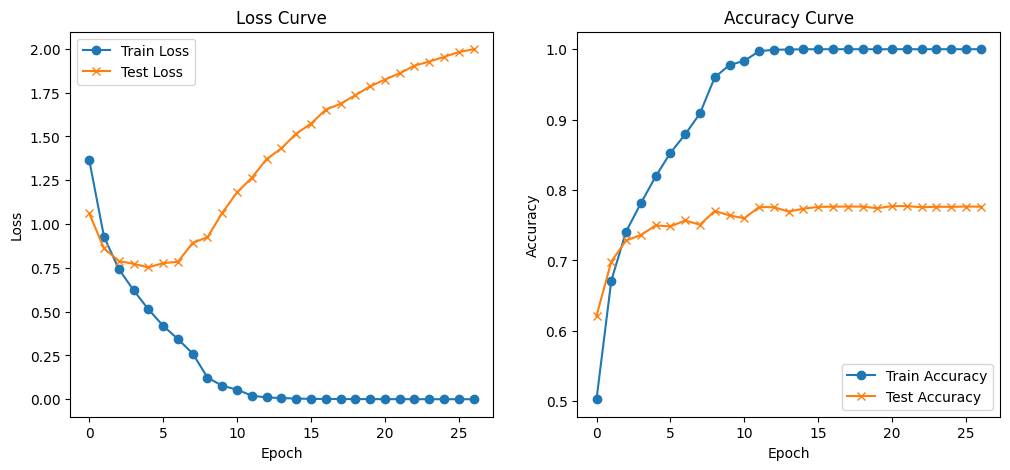

In [10]:
epoch = 1
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

while True:
    print(f"\nEpoch {epoch}")

    # Training
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)

    # Testing
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # Logging metrics
    callback.log(train_cost, test_cost, train_score, test_score)

    # Reduce LR jika loss stagnan
    scheduler.step(test_cost)

    early stopping & save checkpoint
    if callback.early_stopping():
        print("\033[91mEarly stopping triggered!\033[0m")
        break

    epoch += 1

callback.plot_metrics()

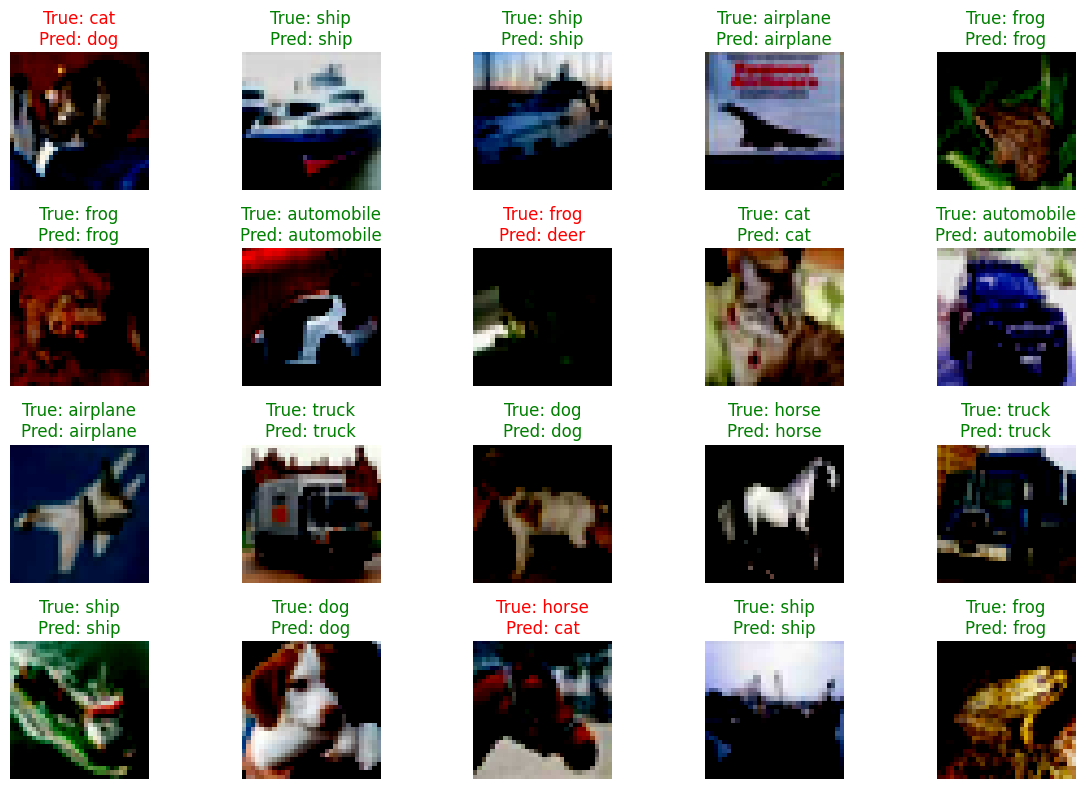

In [11]:
import torch
import matplotlib.pyplot as plt
import torchvision

# Ambil 20 sampel dari testloader
dataiter = iter(testloader)
images, labels = next(dataiter)  # Ambil satu batch

# Pilih hanya 20 data pertama
images, labels = images[:20], labels[:20]

# Pastikan model dalam mode evaluasi
model.eval()

# Prediksi label
with torch.no_grad():
    outputs = model(images.to(device))  # Kirim ke GPU jika tersedia
    _, predicted = torch.max(outputs, 1)  # Ambil indeks kelas dengan skor tertinggi

# Konversi ke CPU untuk ditampilkan
images = images.cpu()
labels = labels.cpu()
predicted = predicted.cpu()

# Menampilkan 20 gambar dengan label asli dan prediksi
fig, axes = plt.subplots(4, 5, figsize=(12, 8))  # Buat grid 4x5
axes = axes.flatten()

for i in range(20):
    img = images[i].permute(1, 2, 0)  # Ubah format channel
    axes[i].imshow(img)
    axes[i].axis("off")

    # Tampilkan label asli & prediksi
    true_label = test_set.classes[labels[i].item()]
    pred_label = test_set.classes[predicted[i].item()]
    color = "green" if true_label == pred_label else "red"

    axes[i].set_title(f"True: {true_label}\nPred: {pred_label}", color=color)

plt.tight_layout()
plt.show()